# In this notebook we will work on predicting the value of football players. The dataset that we are basing this analysis on is from kaggle: https://www.kaggle.com/datasets/kriegsmaschine/soccer-players-values-and-their-statistics

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

In [4]:
# Constructing the path using os.path.join
base_path = r"C:\Users\samue\Documents\GitHub\hsaalen-datamining"
sub_path = "Regression"
folder_name = "football-data"


# 0. Data load

In [64]:
# Loading the data
filenames = ["transfermarkt_fbref_201718", "transfermarkt_fbref_201819", "transfermarkt_fbref_201920"]

path = os.path.join(base_path, sub_path, folder_name)
print(f"Working in path: {path}")

# Construct file paths and read the CSV files
dfs = []
for i, file in enumerate(filenames):
    data = pd.read_csv(os.path.join(path, file + ".csv"),delimiter=';')
    data['year']=2017+i
    dfs.append(data)
    
df = pd.concat(dfs) # Turning the list of dataframes into one dataframe
print("--------------------------------------")
print(f"Amount of samples: {len(df)}. Amount of features: {len(df.columns)}")
print("--------------------------------------")


Working in path: C:\Users\samue\Documents\GitHub\hsaalen-datamining\Regression\football-data
--------------------------------------
Amount of samples: 7108. Amount of features: 402
--------------------------------------


C:\Users\samue\AppData\Local\Temp\ipykernel_24984\244805644.py:10: DtypeWarning: Columns (395) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(path, file + ".csv"),delimiter=';')


In [ ]:
# Identify and remove highly correlated features
df_1718_reduced, dropped_features_1718 = remove_highly_correlated_features(df_1718)
print(f"Amount of dropped features: {len(dropped_features_1718)}.\nDropped features in 2017-2018 dataset: {dropped_features_1718}")


Amount of dropped features: 152.
Dropped features in 2017-2018 dataset: ['games_starts', 'minutes', 'pens_att', 'goals_assists_per90', 'goals_pens_per90', 'goals_assists_pens_per90', 'xg', 'npxg', 'xg_xa_per90', 'npxg_per90', 'npxg_xa_per90', 'minutes_90s', 'shots_total', 'shots_on_target', 'npxg_net', 'passes', 'passes_total_distance', 'passes_completed_short', 'passes_short', 'passes_completed_medium', 'passes_medium', 'passes_completed_long', 'passes_long', 'assisted_shots', 'passes_into_final_third', 'passes_into_penalty_area', 'progressive_passes', 'passes_live', 'passes_pressure', 'crosses', 'passes_ground', 'passes_high', 'sca', 'sca_passes_live', 'sca_passes_dead', 'gca_passes_live', 'tackles_won', 'tackles_def_3rd', 'tackles_mid_3rd', 'dribble_tackles', 'dribbles_vs', 'dribbled_past', 'pressure_regains', 'pressures_def_3rd', 'pressures_mid_3rd', 'blocked_passes', 'touches', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd', 'touches_live_ball', 'dribbles', 'players_dribb

# 1. Data Overview

In [54]:
# Trying to understand the Data
# Looking at the first row to see what columns we have and what kind of values those hold
print("Data Information")
print(df.info())
print("--------------------------------------")
columns = df.columns.values
print(f"Columns: {columns}")

Data Information
<class 'pandas.core.frame.DataFrame'>
Index: 7108 entries, 0 to 2643
Columns: 402 entries, Unnamed: 0 to Column1
dtypes: float64(392), int64(1), object(9)
memory usage: 21.9+ MB
None
--------------------------------------
Columns: ['Unnamed: 0' 'player' 'nationality' 'position' 'squad' 'age' 'birth_year'
 'value' 'height' 'position2' 'foot' 'league' 'games' 'games_starts'
 'minutes' 'goals' 'assists' 'pens_made' 'pens_att' 'cards_yellow'
 'cards_red' 'goals_per90' 'assists_per90' 'goals_assists_per90'
 'goals_pens_per90' 'goals_assists_pens_per90' 'xg' 'npxg' 'xa' 'xg_per90'
 'xa_per90' 'xg_xa_per90' 'npxg_per90' 'npxg_xa_per90' 'minutes_90s'
 'shots_total' 'shots_on_target' 'shots_free_kicks' 'shots_on_target_pct'
 'shots_total_per90' 'shots_on_target_per90' 'goals_per_shot'
 'goals_per_shot_on_target' 'npxg_per_shot' 'xg_net' 'npxg_net'
 'passes_completed' 'passes' 'passes_pct' 'passes_total_distance'
 'passes_progressive_distance' 'passes_completed_short' 'passes_sh

In [55]:
# Set display options to show all rows
pd.set_option('display.max_rows', None)
columns_overview = df.sample(1).T # Transpose the dataset to get a better overview. Also, display some random rows to get a proper understanding of the data.
print(columns_overview)

# Reset the display options after printing
pd.reset_option('display.max_rows')

                                                               1806
Unnamed: 0                                                   2566.0
player                                                Nicolas Viola
nationality                                                  it ITA
position                                                         MF
squad                                                     Benevento
age                                                            27.0
birth_year                                                   1989.0
value                                                     1400000.0
height                                                        180.0
position2                               midfield - Central Midfield
foot                                                           left
league                                                      Serie A
games                                                          24.0
games_starts                                    

In [56]:
print("Missing values in entire dataset")
missing_values= df.isnull().sum()
print(missing_values.sum())

Missing values in entire dataset
84368


# 2. Removing Features 

We have 400 Features which is quite a few. It will be necessary to remove some. One way of doing this is computing the correlation matrix. This is the correlation between features. So, we compare pairs and if a pair has high correlation that means that they are similar. They both hold information that will influence the model in the same way.

In [57]:
# Function to calculate and visualize the correlation matrix
def visualize_corr_matrix(df, target_col="value"):
    """
    Calculate and visualize the correlation matrix of a DataFrame excluding the target column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    target_col (str): The name of the target column to be excluded from correlation calculations.
    
    Returns:
    corr_matrix (pd.DataFrame): The correlation matrix of the features.
    """
    # Exclude the target column
    features_df = df.drop(columns=[target_col])
    
    # Select only numeric columns for correlation matrix calculation
    numeric_df = features_df.select_dtypes(include=[np.number])
    
    # Calculate the absolute value of the correla'tion matrix
    corr_matrix = numeric_df.corr()
    
    # Increase the figure size
    plt.figure(figsize=(20, 16))

    # Plot the heatmap
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
    plt.title("Correlation Matrix Heatmap")
    plt.show()
        
    return corr_matrix


# Function to remove highly correlated features
def remove_highly_correlated_features(df, threshold=0.9):
    """
    Remove highly correlated features from a DataFrame.

    This function calculates the correlation matrix of the DataFrame and removes one feature 
    from each pair of features that have a correlation coefficient greater than the specified threshold. 
    This helps in reducing multicollinearity in the dataset, which can improve the performance of 
    machine learning models.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the features.
    threshold (float): The correlation coefficient threshold above which features are considered highly correlated. 
                       Default value is 0.9.

    Returns:
    df_reduced (pd.DataFrame): The DataFrame with highly correlated features removed.
    to_drop (list): A list of the names of the features that were removed.

    Example:
    df_reduced, dropped_features = remove_highly_correlated_features(df, threshold=0.85)
    """
    # Select only numeric columns for correlation matrix calculation
    numeric_df = df.select_dtypes(include=[np.number])
    
    # Calculate the absolute value of the correlation matrix
    corr_matrix = numeric_df.corr().abs()
    
    # Select the upper triangle of the correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find index of feature columns with correlation greater than the threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    # Drop the highly correlated features
    df_reduced = df.drop(columns=to_drop)
    
    return df_reduced, to_drop

Looking at the correlation matrix to see whether some features are "redundant". We can define a threshold when using the method "remove_highly_correlated_features" that will remove one feature from a highly correlated pair.

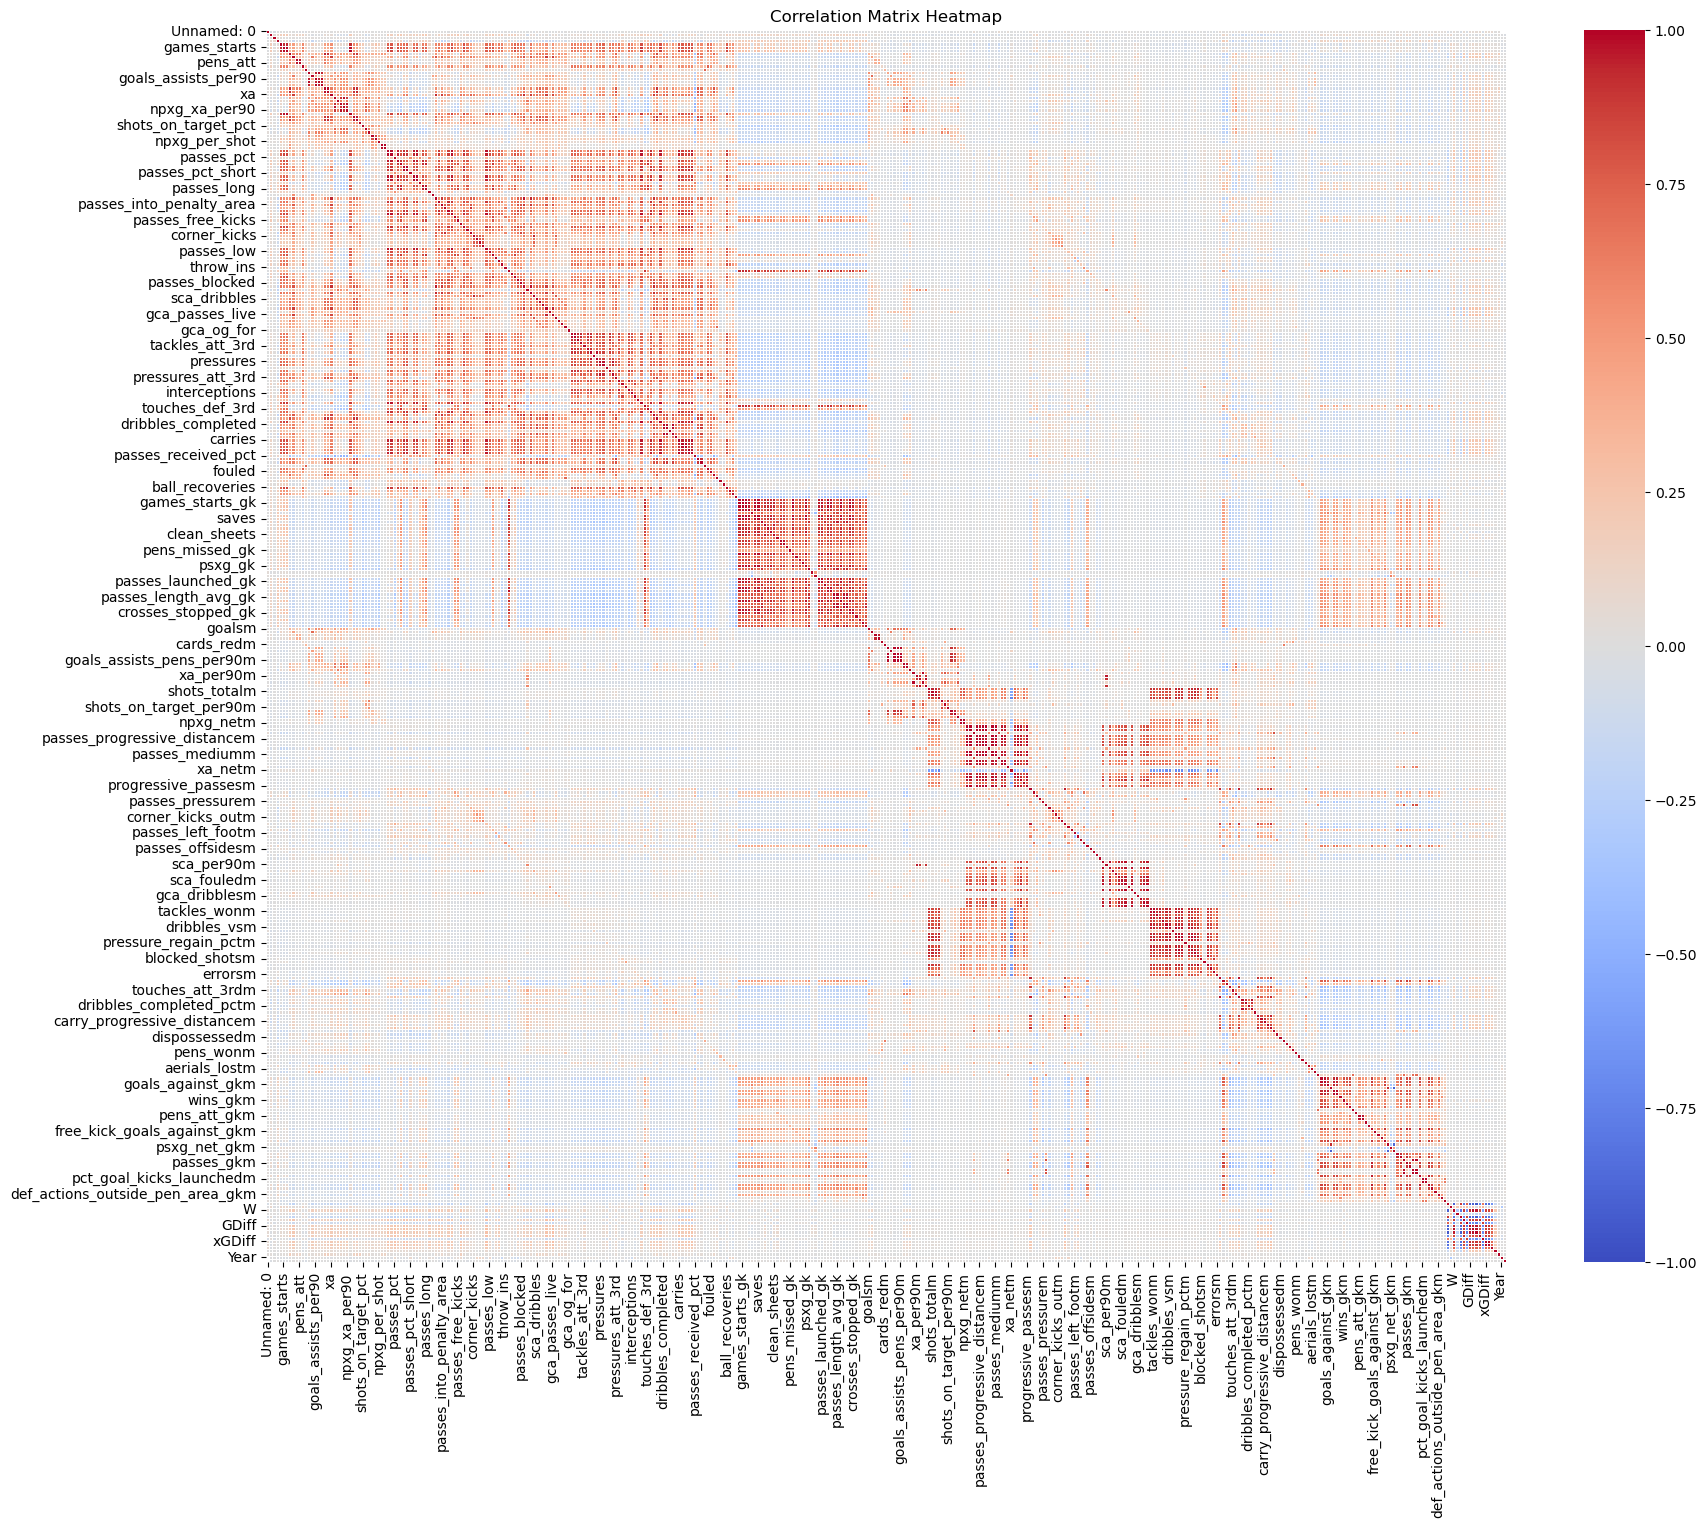

In [58]:
# Visualize the correlation matrix, excluding the target column 'value'
corr_matrix = visualize_corr_matrix(df, target_col='value')

# 3. Splitting Data

Given that new data will always be the upcoming year, I used StratifiedShuffleSplit to have a well distributed train and test set by year.

In [65]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['year']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]

KeyError: '[3560, 2802, 3258, 6865, 6529, 3658, 6411, 6958, 4452, 2859, 3644, 4194, 3947, 4031, 6346, 4958, 5597, 6845, 3759, 2953, 4748, 3618, 4819, 3979, 3523, 6097, 3027, 3207, 4862, 4568, 5818, 3144, 3432, 5561, 6597, 3695, 5095, 4199, 3018, 4991, 5900, 3953, 5679, 6106, 4093, 4120, 5333, 5249, 4040, 7043, 5769, 3390, 5205, 3137, 4734, 3973, 3474, 6911, 3734, 5959, 3028, 4950, 3333, 4158, 4448, 3916, 3374, 6265, 3577, 3788, 5767, 5252, 4117, 3319, 6903, 6866, 4350, 4137, 5447, 5846, 3551, 5132, 3976, 3842, 5236, 4265, 6945, 4225, 5155, 7049, 3557, 6929, 3570, 2904, 3327, 6017, 3300, 3616, 5677, 3056, 4933, 6540, 6689, 3737, 4207, 4181, 5855, 5448, 3469, 4827, 5382, 6669, 7051, 6626, 5143, 3439, 5993, 2909, 5299, 6138, 6934, 5568, 5067, 5251, 3747, 4473, 4121, 5441, 6710, 5087, 4837, 4068, 4719, 4420, 6370, 7105, 3476, 4994, 3289, 5942, 5063, 5552, 2715, 4923, 3796, 4626, 6543, 3251, 2982, 3069, 3201, 3749, 5337, 7034, 6966, 4633, 5526, 6890, 4363, 3822, 3665, 5491, 5042, 6876, 6819, 6588, 3890, 5272, 4436, 6333, 5131, 6444, 4951, 6262, 4711, 2831, 3663, 6784, 2905, 4396, 4224, 5021, 2747, 3249, 6745, 6268, 3527, 6526, 5050, 5073, 2787, 4688, 6421, 3912, 3218, 6998, 6044, 4861, 5174, 3094, 5473, 5257, 5335, 5432, 3770, 4138, 4843, 4757, 4269, 5495, 6790, 3323, 2778, 5136, 3139, 3736, 5739, 6499, 6518, 4481, 5082, 3256, 5541, 5919, 5696, 5924, 5995, 6837, 6615, 4879, 4635, 4960, 6022, 3609, 2702, 3205, 6042, 4547, 6801, 4073, 6193, 3843, 3209, 6808, 3259, 4374, 3189, 3387, 4349, 5460, 4234, 4486, 3227, 4930, 7084, 4302, 4611, 2956, 4603, 4381, 4659, 5857, 3507, 4728, 3526, 7099, 6378, 5330, 5811, 4795, 4750, 7094, 6633, 7090, 4219, 6175, 5075, 4523, 3134, 4770, 2675, 3725, 3235, 3043, 5975, 5353, 6719, 4009, 6045, 5392, 4952, 6913, 4484, 3687, 6121, 3675, 5282, 5053, 5203, 3320, 4651, 5451, 6369, 3828, 6090, 5303, 5324, 5890, 6661, 6886, 6279, 4285, 5043, 4347, 6372, 5913, 3363, 4863, 4071, 4599, 4076, 5628, 4515, 3141, 3279, 6365, 6152, 3260, 3932, 4908, 4186, 5120, 4889, 6239, 4583, 2708, 3702, 2951, 4017, 2761, 4164, 3212, 6456, 3904, 2823, 3355, 6236, 6663, 5502, 5436, 3431, 6511, 6108, 4359, 6921, 6533, 3262, 4536, 6987, 5241, 5853, 3242, 2919, 6355, 2867, 4825, 6990, 4824, 6575, 3277, 5237, 5591, 4183, 6445, 5875, 6725, 5923, 2674, 3052, 3188, 6166, 4371, 3399, 5671, 4939, 2770, 6870, 7085, 6739, 2874, 3247, 2848, 5705, 3330, 3546, 4756, 5224, 5085, 6509, 3798, 3361, 4816, 3008, 6937, 4617, 5521, 3632, 6869, 2822, 3184, 6795, 7023, 6201, 4390, 2885, 2995, 3832, 2700, 6667, 4493, 5906, 5762, 3789, 2737, 4671, 4212, 3612, 3712, 3150, 2841, 6970, 2872, 5829, 3096, 5687, 3111, 5976, 6486, 7080, 4015, 6047, 6040, 5215, 4115, 5466, 6251, 4306, 3245, 3381, 2834, 4789, 4176, 6653, 4075, 2795, 3234, 4973, 4129, 3896, 2750, 5785, 5175, 3089, 5868, 3307, 4206, 5816, 5819, 6731, 6473, 4107, 2756, 5404, 5765, 5727, 6011, 4613, 4327, 6759, 6729, 4449, 4109, 5849, 5523, 6547, 5551, 3511, 4065, 4326, 4187, 4506, 6397, 3002, 4035, 5199, 6143, 3705, 4919, 6621, 5718, 3197, 4860, 6158, 3420, 6170, 2922, 2717, 2868, 7077, 2706, 6530, 5618, 6880, 3821, 5250, 6658, 4532, 3638, 3158, 2842, 3902, 6067, 6241, 3501, 4145, 4257, 3240, 6431, 2796, 5323, 5779, 6773, 3085, 2705, 4130, 4775, 5118, 5018, 4177, 6756, 5354, 5663, 5885, 5126, 6269, 4340, 5592, 3097, 4574, 5015, 6358, 6146, 4891, 4745, 6590, 5921, 6991, 4977, 6619, 6980, 6013, 3562, 2648, 6883, 4018, 3863, 3698, 4250, 3682, 6938, 6926, 4365, 4408, 4438, 5884, 5983, 3444, 5681, 6650, 6041, 3308, 3318, 5714, 3846, 6472, 3382, 3090, 5936, 2941, 2912, 6881, 3046, 3135, 4488, 3287, 2977, 6605, 5170, 5905, 3048, 5951, 7058, 2739, 5685, 3386, 2968, 4558, 3949, 6830, 6426, 2897, 2969, 5365, 3034, 7057, 4230, 6144, 4780, 4067, 6281, 4020, 3127, 3602, 6792, 3535, 3454, 6824, 2801, 6243, 3806, 6678, 5485, 4980, 3376, 6342, 3573, 5371, 4563, 4341, 4108, 5483, 5689, 4809, 3753, 3735, 3848, 3530, 3081, 5759, 3107, 5601, 5840, 3574, 3532, 4216, 6500, 4227, 5375, 5901, 6674, 4046, 4024, 6222, 4047, 4644, 2958, 5847, 6697, 3099, 6110, 5518, 2945, 6753, 5894, 3883, 6072, 2879, 6208, 5639, 5638, 3396, 6360, 6640, 4260, 5011, 4555, 3873, 3694, 6715, 6922, 4999, 5443, 4013, 3649, 6066, 3471, 3709, 3915, 4605, 5412, 4395, 5583, 6349, 6306, 3941, 6769, 5861, 3582, 3666, 3109, 6373, 5210, 3937, 3628, 3295, 5505, 6400, 6894, 6320, 3113, 4813, 5971, 3306, 3288, 7007, 4101, 6416, 5070, 3951, 6767, 3994, 4836, 5620, 6376, 6261, 5084, 2658, 4430, 5000, 5556, 4135, 5191, 6080, 4676, 6035, 4964, 3369, 3108, 4051, 6684, 6639, 5474, 3754, 3180, 6449, 6860, 4214, 6744, 6920, 4056, 3161, 7061, 6495, 4640, 6206, 5345, 5014, 6550, 6537, 2797, 6714, 6838, 6304, 4294, 3309, 6147, 2740, 7086, 6595, 5543, 3098, 6768, 6951, 3531, 3547, 6535, 2710, 5400, 6711, 3225, 5643, 4637, 4311, 2844, 4720, 4570, 4237, 3424, 6613, 4078, 2896, 5887, 3929, 6155, 6454, 3391, 5105, 5570, 2954, 3824, 6884, 5178, 5710, 3368, 2985, 5594, 4508, 4141, 6339, 6429, 4039, 5864, 5207, 4048, 4785, 4161, 3220, 6555, 5398, 4223, 6161, 6770, 5711, 3517, 4709, 6167, 6322, 2824, 4526, 6797, 6440, 5262, 4820, 5978, 5116, 5837, 5511, 6687, 5010, 3100, 4631, 3485, 3850, 6867, 5459, 6176, 5947, 3372, 5488, 3681, 3406, 6380, 3707, 6448, 3891, 3210, 2744, 2937, 4686, 4627, 4500, 3801, 5049, 6113, 2805, 6594, 6474, 3413, 4361, 4328, 3651, 6381, 3266, 4942, 5411, 7066, 5245, 3525, 2657, 5213, 3790, 6742, 6177, 3778, 3460, 3062, 6101, 2837, 5987, 3042, 2898, 4575, 4012, 3426, 6873, 5307, 2808, 6839, 6275, 3138, 6827, 5522, 6178, 5012, 3659, 2987, 5542, 5133, 3800, 5167, 6833, 4639, 5512, 6564, 6316, 5544, 6593, 5504, 3341, 5733, 5750, 4014, 6623, 4510, 5086, 6307, 6812, 5390, 5654, 3047, 5313, 3371, 5929, 5414, 4044, 3720, 3995, 5222, 6566, 5048, 3080, 4822, 4289, 4826, 3453, 6781, 4461, 5147, 6305, 4898, 5329, 5833, 3838, 3779, 4981, 3631, 3601, 5941, 7044, 3166, 5031, 4297, 4707, 4492, 6134, 3630, 5223, 4342, 6531, 6117, 6848, 3685, 5865, 4415, 5880, 6418, 2800, 6919, 2949, 2862, 3704, 2689, 4724, 4590, 5665, 2684, 6393, 3621, 3271, 5609, 5423, 3732, 2816, 6015, 4661, 4899, 2743, 3679, 6051, 4894, 3380, 6765, 4166, 2766, 3888, 6603, 3554, 6120, 6931, 6216, 3054, 5265, 6194, 5525, 3165, 6084, 5735, 5738, 2913, 5298, 5586, 4608, 5202, 4238, 6364, 4647, 5646, 4794, 5584, 4595, 6622, 5352, 2881, 3879, 5992, 6693, 4157, 5934, 6463, 5238, 2974, 4030, 6187, 2701, 3942, 6553, 5632, 4612, 6560, 3437, 3744, 3865, 4997, 6467, 3032, 6135, 3875, 2662, 7104, 5910, 7033, 5667, 6964, 3599, 6736, 5349, 5997, 4781, 3414, 6399, 5965, 4309, 4811, 7097, 3515, 6671, 3463, 5690, 6122, 2678, 3130, 4571, 3392, 5035, 4113, 4373, 5680, 3568, 4873, 6413, 3131, 7011, 3905, 4300, 4792, 5648, 7019, 3346, 4646, 3294, 2857, 5002, 5064, 6868, 5624, 3808, 4007, 3866, 3786, 3211, 4520, 4810, 3430, 4041, 4779, 2690, 4903, 6272, 3794, 3199, 6943, 4170, 4465, 5019, 4105, 4435, 5527, 4799, 5145, 6591, 4228, 4054, 4189, 5682, 6748, 7047, 4201, 4165, 4060, 5859, 2947, 4478, 6760, 6057, 6976, 5294, 5080, 4776, 5575, 3993, 5798, 2738, 5678, 5790, 4849, 5606, 4736, 3273, 2650, 6645, 3409, 3579, 5458, 6030, 4925, 4727, 6888, 5263, 3565, 4979, 6522, 6785, 5715, 2948, 5248, 3982, 5641, 3877, 5860, 3181, 3036, 3710, 3861, 3797, 3074, 2709, 3619, 4459, 5332, 4266, 6005, 4998, 6211, 5805, 6993, 4010, 6724, 4159, 3849, 4721, 3969, 6050, 4364, 5782, 3101, 5492, 5828, 3534, 2804, 3065, 7050, 4955, 3884, 6439, 5090, 4738, 6367, 4774, 6638, 6271, 3305, 5302, 2711, 5083, 6821, 4807, 3351, 6009, 3063, 5751, 5292, 2858, 2818, 5795, 7015, 3620, 3791, 7079, 5892, 5385, 5904, 4160, 2992, 4016, 5336, 6985, 3492, 4654, 2659, 3567, 5158, 4005, 5810, 4557, 2723, 6195, 3756, 4765, 3952, 4200, 2793, 4413, 6075, 7093, 4150, 6982, 7082, 3729, 3078, 2959, 4630, 3950, 4103, 6185, 6260, 5108, 6203, 3228, 5946, 4336, 4895, 4399, 6515, 6464, 4319, 3859, 5550, 4924, 4134, 2907, 5344, 5874, 5966, 6728, 4622, 4865, 6843, 4004, 6878, 7029, 5446, 5421, 4882, 4125, 5540, 3136, 5563, 5655, 5619, 7014, 4906, 3558, 5276, 5482, 4378, 5737, 5269, 6606, 4142, 3519, 4063, 5286, 4546, 4648, 6503, 6039, 4112, 7054, 3742, 7071, 5498, 5630, 6902, 4616, 4783, 3169, 3468, 5402, 7072, 4845, 3930, 5274, 4314, 3961, 5538, 3497, 3448, 5493, 5065, 6741, 4801, 5039, 5341, 5574, 3257, 5163, 7040, 6889, 7087, 2819, 4454, 5660, 6287, 4062, 2679, 3518, 6023, 4691, 4628, 4818, 5430, 5820, 3038, 4489, 3331, 3447, 3275, 5781, 5291, 3771, 6923, 4401, 4111, 6375, 3337, 3088, 6014, 4376, 4609, 3569, 2727, 6512, 5397, 5754, 4983, 3358, 6887, 2815, 6455, 2779, 6738, 3449, 6361, 6230, 3983, 5571, 3669, 6571, 5218, 6257, 5720, 5320, 5281, 4268, 2980, 3851, 5469, 4096, 3102, 5219, 4725, 5168, 6813, 5429, 5129, 4472, 6466, 4907, 2866, 5897, 5844, 6153, 6664, 4487, 6582, 5271, 2806, 3155, 2952, 3143, 3692, 2983, 4959, 5025, 6225, 2742, 4195, 5712, 6814, 6064, 6836, 2889, 3750, 6059, 5112, 3425, 4692, 4205, 4703, 4251, 3055, 2899, 3901, 3668, 3005, 3611, 4755, 5673, 6662, 5487, 5621, 4066, 2720, 4885, 6771, 5377, 4552, 6939, 6173, 2850, 4468, 2646, 3459, 3328, 3939, 5456, 3219, 5707, 3762, 4543, 2875, 7035, 3329, 4337, 4126, 3787, 4287, 5347, 3373, 3583, 4208, 3450, 3395, 5835, 4947, 4218, 5150, 4929, 3465, 4582, 2962, 3340, 3802, 7008, 3445, 2910, 4057, 5476, 6383, 3336, 3405, 3160, 2843, 4358, 4388, 6665, 2847, 5508, 6190, 4475, 4965, 5725, 6641, 5343, 5708, 5622, 2890, 6548, 6651, 5699, 3812, 3745, 3899, 6205, 6647, 5328, 6149, 4003, 6114, 3421, 6557, 6482, 5106, 3934, 4760, 2745, 4162, 4678, 3895, 6713, 4455, 7060, 2986, 3490, 7091, 5772, 3415, 3153, 5836, 6733, 2943, 6282, 6508, 6453, 4299, 3958, 4698, 2877, 3634, 3936, 4403, 5676, 5794, 6856, 4193, 4385, 2821, 6172, 3151, 3586, 6428, 2676, 5200, 4092, 2790, 5989, 7001, 3338, 6182, 6079, 3104, 3784, 7032, 3739, 2966, 7024, 4682, 4519, 6099, 6786, 4666, 6815, 2763, 2915, 3140, 3347, 5964, 3064, 3672, 3284, 5351, 6910, 6660, 5611, 4470, 3343, 3233, 3353, 3264, 6829, 4772, 2734, 4704, 5612, 5915, 4090, 6679, 6308, 6783, 4876, 5497, 6340, 6331, 3676, 4744, 3664, 4128, 6123, 7025, 5931, 3049, 2769, 6624, 2882, 2660, 6493, 5850, 2789, 5176, 6630, 5672, 5165, 3766, 3456, 4088, 4806, 6896, 3290, 6849, 6199, 6941, 3831, 5813, 2663, 5256, 3654, 6835, 6559, 3200, 5472, 4871, 4152, 3350, 3656, 6956, 5463, 3566, 5160, 3818, 5431, 6068, 5169, 6683, 6025, 4293, 3795, 6905, 5235, 6160, 3933, 3783, 6954, 5159, 4229, 6417, 4990, 5826, 6734, 3642, 5848, 2933, 3922, 3125, 5419, 5982, 6096, 6168, 5554, 3278, 5045, 6643, 7068, 6636, 5040, 6131, 5161, 2961, 5645, 5013, 3537, 5273, 4357, 7018, 5748, 5391, 3590, 4032, 3013, 6053, 5208, 5092, 3095, 3316, 4946, 2884, 5728, 5209, 3552, 6116, 6382, 2923, 3639, 5372, 3572, 6891, 3016, 6470, 4425, 3398, 3999, 6327, 3082, 2762, 3944, 3041, 6196, 6817, 3148, 3417, 6228, 4743, 4694, 4405, 3505, 7089, 5462, 4840, 3393, 4239, 5461, 4132, 5467, 2725, 5358, 5797, 4584, 6646, 5757, 5927, 3780, 2752, 5939, 6246, 4094, 6488, 6749, 2984, 3945, 5674, 4864, 6635, 5545, 5607, 6104, 6132, 4155, 4398, 4710, 4797, 6996, 5378, 2926, 6694, 5610, 4102, 4927, 6299, 5774, 4653, 7073, 6618, 5189, 2749, 4530, 6644, 6524, 6850, 3814, 7031, 6549, 7106, 3394, 3446, 5872, 6087, 4842, 3149, 3462, 6752, 4831, 3384, 6708, 6871, 5081, 6977, 5972, 5450, 4514, 2773, 5041, 2887, 5259, 4119, 5876, 6141, 4202, 6712, 5709, 5533, 4497, 4085, 5806, 5768, 4660, 4715, 6501, 3777, 6089, 2830, 4784, 3226, 2979, 5893, 5370, 3680, 6071, 4767, 4576, 4564, 5135, 5471, 4426, 7028, 6609, 3509, 5211, 7092, 3112, 5242, 6487, 2869, 6024, 4144, 7013, 4569, 6831, 3367, 6018, 5633, 5359, 4204, 6791, 2835, 3992, 5824, 5490, 4566, 5573, 6442, 5608, 6596, 5831, 4662, 6688, 4366, 6895, 3844, 6757, 5366, 4521, 3073, 3633, 6297, 6302, 3334, 6698, 2900, 2647, 2955, 5051, 6516, 3673, 5164, 3246, 4001, 3764, 4614, 6103, 3943, 5395, 3730, 6392, 3728, 4970, 3075, 4196, 5953, 5922, 5057, 2809, 5548, 6298, 3627, 2722, 6237, 3003, 5283, 4504, 4963, 3121, 3178, 5489, 5363, 6747, 4672, 5895, 4548, 4410, 2817, 5038, 6780, 6112, 3594, 6498, 6914, 5683, 4701, 6086, 2976, 6776, 3617, 5030, 4538, 6565, 4967, 5017, 5691, 4753, 5387, 6136, 3966, 6480, 2757, 3364, 3513, 3261, 6906, 3892, 6357, 4226, 3977, 6457, 3229, 2695, 5703, 6012, 6288, 6659, 3538, 3379, 5717, 3162, 6291, 4261, 3058, 6709, 4028, 4697, 3510, 5212, 4645, 6247, 2965, 3050, 5963, 4561, 5613, 4167, 4272, 5950, 6348, 4777, 5741, 4153, 4418, 3118, 5617, 3990, 5907, 7067, 4283, 3198, 4118, 4274, 6521, 3092, 5916, 5771, 3370, 4652, 4673, 5596, 3504, 3604, 4700, 5033, 4839, 6992, 4343, 2726, 5410, 3857, 4270, 2681, 4173, 3610, 6386, 6256, 5652, 5634, 6082, 3804, 6422, 6735, 3217, 3914, 4754, 3661, 3653, 4763, 4586, 3867, 6589, 5052, 5289, 5843, 6052, 3928, 4591, 6737, 6284, 5214, 2936, 3349, 4580, 4464, 2997, 4174, 3480, 5515, 2685, 6793, 5144, 5804, 3029, 5734, 3603, 5692, 6224, 5394, 6231, 4080, 4149, 6385, 6434, 5270, 5264, 2759, 5647, 5468, 5845, 5225, 6249, 3120, 3711, 4215, 6893, 6019, 6610, 5228, 5974, 5008, 5076, 4106, 4148, 5902, 6854, 5730, 2716, 4382, 5154, 3520, 6184, 3312, 6552, 6579, 5004, 5760, 4716, 3716, 5157, 5653, 6961, 2707, 6699, 4940, 4527, 3591, 2944, 4303, 6485, 6323, 3185, 3667, 5852, 6774, 4367, 3880, 5903, 4920, 4817, 5088, 4254, 6527, 5216, 3440, 4095, 3493, 5948, 4833, 3496, 2748, 4742, 5775, 4335, 4273, 6446, 5206, 6979, 6481, 5637, 3852, 6324, 6947, 6478, 2811, 6726, 4246, 4935, 4649, 5955, 5932, 2849, 6374, 6061, 2870, 4793, 4087, 4317, 3751, 5304, 5564, 5024, 5234, 4870, 4559, 6476, 5193, 4042, 3625, 4677, 4099, 6857, 2735, 5822, 4621, 2820, 3283, 5958, 3252, 4124, 3071, 5566, 4424, 4741, 5266, 3645, 7048, 6601, 3763, 3919, 2699, 3701, 4852, 6794, 4259, 2832, 3793, 3954, 3987, 4844, 5261, 5675, 4421, 6328, 5888, 6377, 4353, 4084, 3255, 3856, 5800, 5770, 3853, 5310, 5863, 3190, 4025, 3117, 4787, 4496, 4740, 6652, 6634, 3072, 6325, 6021, 5567, 5314, 6673, 2718, 3293, 2940, 6525, 5478, 5428, 3556, 5528, 3847, 6577, 6862, 2775, 6347, 6489, 5305, 4384, 4249, 4663, 4972, 5094, 3026, 6081, 6872, 3767, 4712, 4554, 5194, 3970, 3291, 6584, 4512, 4986, 5565, 5327, 4477, 5764, 6519, 3434, 2994, 4021, 3419, 4643, 6852, 5879, 4345, 4479, 5331, 6008, 6701, 3545, 6676, 5449, 3045, 5636, 3377, 3267, 4352, 7053, 6918, 5258, 4525, 6762, 3035, 4498, 5747, 6483, 3057, 3296, 3310, 3927, 4874, 2988, 3823, 3302, 6310, 6690, 6105, 3887, 5866, 6107, 4417, 4562, 3170, 7052, 3068, 6410, 6544, 3122, 4045, 4954, 4618, 3182, 3388, 3116, 5697, 5627, 3274, 5640, 5037, 3239, 4782, 5479, 5056, 5656, 6988, 3232, 2981, 5123, 3549, 6608, 6971, 4987, 3605, 2876, 6534, 6648, 3022, 6680, 4601, 5579, 6001, 3221, 2853, 3254, 4854, 2996, 3782, 4262, 4480, 6459, 3145, 2703, 6125, 3402, 3864, 2691, 4456, 4483, 4877, 4909, 2839, 6029, 5309, 6520, 4091, 5190, 6036, 4055, 5496, 6822, 4277, 2970, 5509, 5553, 5003, 6806, 5444, 3597, 4915, 3776, 5899, 3408, 6267, 3335, 5507, 5217, 6192, 3837, 3774, 3714, 6309, 3486, 4509, 3126, 3086, 6787, 4288, 5406, 6189, 2781, 5173, 3724, 6250, 6506, 4717, 7022, 5022, 6978, 3110, 5318, 6730, 5985, 3183, 6917, 3855, 5746, 6091, 4026, 2886, 3688, 6403, 3626, 6523, 4982, 6574, 6235, 3238, 5247, 6983, 6140, 3946, 4362, 5821, 3297, 5139, 5784, 5231, 4419, 6058, 5891, 4641, 6796, 6505, 5477, 6604, 3164, 5437, 3241, 5577, 4592, 3025, 6743, 4803, 5197, 4255, 7002, 6491, 4632, 4867, 4184, 2891, 5745, 5110, 6469, 4790, 2828, 4585, 4976, 6882, 3731, 3403, 4429, 3978, 6904, 4315, 6283, 4387, 5152, 5239, 4747, 3984, 5651, 6625, 3494, 3768, 5572, 5166, 5980, 4022, 4851, 4491, 3811, 3775, 6227, 6908, 6877, 6443, 6901, 3522, 4236, 6070, 7055, 3981, 4587, 4593, 3722, 4086, 5981, 6702, 4539, 4664, 4597, 6935, 3813, 5883, 5524, 3115, 4830, 4471, 3404, 4333, 3000, 3869, 4380, 3989, 5732, 4460, 4723, 5988, 6532, 6366, 7012, 4280, 4034, 5898, 3276, 3407, 5595, 3093, 4179, 6273, 5099, 5777, 5935, 6561, 2758, 4169, 3706, 2845, 4522, 6046, 3044, 4638, 6502, 6556, 6782, 3059, 4332, 6800, 4761, 3647, 3623, 6805, 3588, 6352, 6898, 6975, 6318, 4541, 7039, 7003, 3841, 3940, 6513, 6484, 6128, 6395, 5260, 6940, 4372, 4198, 6465, 5510, 5786, 5055, 6924, 3589, 6248, 2767, 6432, 5532, 5278, 6691, 3803, 4304, 4730, 3868, 6430, 5104, 5702, 6611, 6425, 4518, 5440, 3215, 6026, 5555, 3451, 5625, 6171, 5427, 4495, 2654, 5342, 3502, 3292, 4097, 4070, 5839, 6461, 4685, 2788, 4232, 6707, 5192, 6062, 5537, 5588, 4620, 5832, 3023, 5253, 6259, 6438, 5179, 4607, 6563, 6754, 4213, 4866, 6350, 4469, 3533, 6341, 3514, 4409, 3548, 5433, 3641, 4921, 3955, 3203, 5156, 4291, 5339, 5792, 5684, 5384, 5368, 6546, 6398, 5662, 6959, 6174, 4796, 5061, 5317, 4171, 6293, 3636, 6326, 3489, 6043, 6578, 2666, 4069, 4248, 7037, 5928, 6933, 4278, 3250, 6016, 6198, 3836, 4038, 3624, 4788, 3324, 6388, 4240, 7009, 6217, 3555, 5649, 5506, 3825, 3303, 5220, 4984, 5059, 3467, 3236, 6210, 3830, 6098, 4271, 3412, 2942, 4886, 5635, 6452, 3910, 6675, 2989, 3378, 3826, 4786, 3748, 6586, 5069, 6562, 5119, 3917, 3142, 4318, 2736, 4050, 2682, 6727, 4406, 4883, 3686, 3317, 4258, 4916, 6942, 4351, 3037, 5644, 7027, 4330, 5001, 6775, 4579, 5529, 4969, 2814, 2671, 2929, 5068, 5701, 2760, 2911, 4936, 4804, 3935, 3563, 5834, 2880, 6336, 7059, 3773, 3550, 5908, 5453, 3442, 4665, 5393, 4681, 6092, 3286, 3542, 3173, 6804, 2972, 3827, 4256, 5275, 3133, 5666, 2851, 3146, 3495, 6861, 5842, 3521, 4872, 3909, 5949, 4431, 3834, 4634, 4675, 6337, 6197, 6750, 6420, 6405, 6779, 6000, 5603, 6654, 3559, 4943, 5401, 4878, 5016, 3196, 5316, 5787, 3972, 4917, 3997, 3070, 2920, 2908, 3585, 3039, 3397, 4414, 3959, 5138, 5338, 4856, 3281, 4731, 5130, 4945, 5873, 5700, 2813, 7020, 5322, 6088, 4400, 3222, 3693, 6063, 3009, 2693, 3124, 4356, 6100, 3282, 3461, 3894, 4422, 5026, 6414, 4392, 3719, 4338, 6541, 6007, 4279, 5029, 5973, 4550, 4411, 5896, 6258, 6391, 5306, 6329, 5149, 3708, 4934, 4064, 3083, 3191, 5078, 6642, 2964, 5736, 4375, 5503, 2713, 3715, 6840, 6163, 4989, 3629, 7074, 5650, 6436, 6587, 5869, 3960, 7100, 5943, 3298, 6957, 6820, 5287, 4323, 6441, 6020, 6554, 4706, 4383, 4551, 4911, 4905, 4914, 3060, 3564, 3713, 2668, 5315, 6451, 5789, 6277, 6095, 3598, 4589, 4900, 4932, 6799, 5186, 6065, 4267, 2683, 4598, 3907, 6435, 3964, 4501, 2932, 5657, 7069, 2916, 7081, 3529, 5670, 2649, 4394, 4528, 7063, 4835, 4985, 6127, 6069, 6655, 3703, 4680, 6006, 5589, 5128, 6157, 5452, 2791, 5925, 6967, 5944, 2776, 5096, 5761, 4696, 5032, 3129, 4002, 4011, 3030, 5201, 5979, 6915, 4147, 2950, 4735, 5766, 3528, 3506, 2963, 4191, 6332, 5862, 6409, 3578, 5917, 4922, 6818, 3304, 3410, 6450, 6033, 5277, 5009, 5799, 6229, 6274, 5731, 3871, 6777, 6542, 5380, 3019, 6855, 3733, 5602, 6150, 2826, 6124, 5187, 5111, 4133, 2672, 4560, 3683, 6266, 2846, 4404, 4485, 5426, 4296, 5255, 6492, 2906, 6226, 6614, 4623, 7030, 3360, 3858, 6285, 5788, 6984, 3270, 3540, 3156, 3741, 5074, 4815, 6164, 5115, 5340, 6832, 3128, 2978, 6215, 3553, 3758, 4808, 6156, 4615, 2697, 4505, 2755, 3418, 3006, 3208, 3541, 2852, 5940, 6637, 4079, 2661, 5044, 2938, 5807, 6303, 4354, 4443, 5072, 2780, 5434, 3015, 5723, 5918, 6354, 4596, 4931, 5177, 4156, 3345, 3968, 7017, 7062, 4008, 4542, 5744, 3010, 6981, 7102, 3840, 4722, 4178, 4893, 4687, 2827, 5233, 4769, 4732, 3512, 3147, 3429, 6620, 5999, 5360, 6732, 6264, 3017, 3243, 3500, 5520, 5970, 3332, 6165, 4729, 2686, 4379, 3326, 5424, 6048, 6334, 6296, 5020, 5124, 5141, 6802, 3965, 6115, 4298, 4263, 3206, 4726, 5749, 3596, 5870, 2798, 6973, 4389, 5793, 3159, 4537, 5146, 2871, 6853, 3524, 6363, 5300, 6656, 6056, 6962, 4453, 3157, 3204, 6569, 4203, 3269, 5093, 3576, 5858, 5373, 3587, 2784, 6280, 5587, 5204, 5023, 6253, 5729, 3344, 4104, 6191, 3470, 4636, 3433, 3923, 4123, 5198, 5066, 4937, 4290, 2902, 3342, 4316, 6583, 6916, 6379, 2664, 6223, 5379, 2729, 6772, 5127, 2799, 3079, 2783, 3458, 5881, 3172, 3860, 4324, 3561, 4549, 2925, 4308, 6351, 3723, 6823, 5519, 4321, 2810, 3457, 4529, 5062, 6592, 5991, 6670, 4926, 4544, 3717, 4746, 5817, 6133, 6950, 2724, 3487, 2914, 2924, 4386, 2918, 4764, 6925, 5445, 4594, 2960, 6798, 3643, 6657, 5642, 4346, 3765, 3613, 2967, 4881, 5534, 7042, 6514, 4766, 3348, 4705, 7006, 3606, 6580, 3443, 2930, 4136, 4901, 5706, 4674, 6353, 5180, 2865, 4368, 5604, 3106, 5977, 6314, 3854, 5593, 6766, 6313, 3810, 5882, 6003, 5422, 4220, 7046, 3882, 7056, 6995, 6119, 5914, 3650, 4295, 5776, 6034, 3389, 6705, 5230, 4131, 3040, 5713, 6740, 3452, 5539, 5514, 4444, 3670, 4996, 5945, 6944, 4006, 5803, 3313, 5355, 6032, 4695, 6761, 6551, 3971, 6077, 5937, 3175, 5629, 5513, 2901, 4533, 3962, 3202, 4966, 2928, 6129, 2665, 5889, 3926, 6986, 3061, 3595, 4904, 6362, 5102, 2993, 4072, 5780, 3192, 5357, 3362, 5007, 5809, 6668, 3699, 3581, 3898, 4127, 4077, 3975, 2863, 4896, 7101, 4857, 6232, 4890, 6477, 6576, 4320, 3889, 5326, 4074, 3491, 6335, 3874, 5956, 4439, 7041, 4941, 5626, 3593, 5058, 4175, 5481, 4402, 6863, 3761, 3436, 6002, 4588, 6755, 6875, 3314, 6672, 5171, 5417, 3696, 4821, 5661, 2971, 5006, 4524, 5517, 7000, 6214, 3224, 5311, 2935, 6545, 5470, 3700, 5773, 4490, 4859, 3820, 3769, 7045, 6390, 6628, 4565, 4467, 3356, 4029, 3084, 3985, 3231, 5279, 2655, 6254, 4749, 7098, 2782, 4975, 4391, 6598, 5140, 5871, 4938, 5615, 4888, 3757, 4581, 4832, 5961, 5396, 2854, 5499, 6242, 3301, 2836, 3499, 5930, 2764, 5659, 6145, 5962, 2838, 2669, 5054, 3401, 5297, 4625, 6581, 3897, 4718, 7083, 6763, 3322, 6404, 3924, 3974, 5582, 6204, 5484, 3498, 3752, 4884, 3213, 6180, 6602, 6930, 6290, 6960, 6183, 2807, 3472, 3689, 4312, 5778, 6558, 5952, 5878, 2732, 5089, 4841, 6539, 6300, 2786, 5536, 4902, 6632, 5486, 3103, 4848, 2733, 4679, 6126, 4974, 4275, 6027, 2714, 6716, 5838, 2991, 3186, 2677, 2670, 4122, 3727, 5740, 6102, 3580, 3423, 5227, 6616, 6344, 7107, 6219, 4798, 4737, 3400] not in index'